<a href="https://colab.research.google.com/github/UOH-Group3-Project/Hackathon_group3/blob/main/Challenge_submission_group3_order2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flu Vaccination Prediction - Dataset A
## Postgraduate Data Science Hackathon
### Complete Machine Learning Pipeline

### Group Name:GROUP-3

**Group Members:**

S. No.	Name	Student ID
1	Bollam sai Mohan	23027511
2	Dhanush reddy kankanala	23040217
3	Gopi Erla 	23040971
4	Jashwanth nallaparaju	23041020
5	Narender reddy Ranabothu	23039923
6	Pavan Kumar Reddy	23005922
7	Pranay Reddy Bandharapu	23028438
8	Rakesh Kummari	23029280
9	Rohit Jasthi	23007975
10	Venugopal Narsingu	23038343

This notebook performs end-to-end machine learning modeling to predict
whether a respondent received a seasonal flu vaccine (seasonal_vaccine).

### Author: Data Science Hackathon Participants

### Date: October 2025

# 1. SETUP & DATA LOADING

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# machiiine learning libs
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except:
    LIGHTGBM_AVAILABLE = False
    print("Note: LightGBM not available, will use alternative models")

# Evaluation Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix, roc_curve)

# Explainability
import shap

#random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"Random State: {RANDOM_STATE}")

✓ All libraries imported successfully!
Random State: 42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Load Datasets

In [ ]:
# training data
train_df = pd.read_csv('dataset_A_training.csv')
print(f"\n✓ Training data loaded: {train_df.shape}")

#testing
test_df = pd.read_csv('dataset_A_testing.csv')
print(f"✓ Testing data loaded: {test_df.shape}")

# sample submission format
example_submission = pd.read_csv('dataset_A_example_submission.csv')
print(f"✓ Example submission loaded: {example_submission.shape}")


✓ Training data loaded: (4756, 31)
✓ Testing data loaded: (4749, 30)
✓ Example submission loaded: (4749, 2)


## Initial Data Exploration

In [ ]:
print("TRAINING DATA OVERVIEW")

print("\nFirst 5 rows:")
display(train_df.head())

print("\nDataset Information:")
train_df.info()

print("\nBasic Statistics:")
display(train_df.describe())

print("\nMissing Values:")
missing_counts = train_df.isnull().sum()
missing_percent = (missing_counts / len(train_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_counts[missing_counts > 0],
    'Percentage': missing_percent[missing_counts > 0]
}).sort_values('Percentage', ascending=False)
display(missing_df)

print("TESTING DATA OVERVIEW")
print(f"\nShape: {test_df.shape}")
print(f"Columns: {test_df.columns.tolist()}")

# Verify target variable is not in test set
if 'seasonal_vaccine' in test_df.columns:
    print("⚠ Warning: Target variable found in test set!")
else:
    print("✓ Target variable correctly absent from test set")

TRAINING DATA OVERVIEW

First 5 rows:


,respondent_id,flu_concern,flu_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,employment_sector,seasonal_vaccine
0,1,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,Non-MSA,0.0,0.0,entertainment,0
1,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Male,NaN,Not Married,Rent,Employed,"MSA, Principle City",1.0,0.0,real_estate,0
2,3,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,Male,"> $75,000",Married,Own,Not in Labor Force,"MSA, Not Principle City",1.0,0.0,NaN,0
3,4,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Male,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",1.0,2.0,utilities,1
4,5,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,"MSA, Not Principle City",2.0,0.0,NaN,0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756 entries, 0 to 4755
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                4756 non-null   int64  
 1   flu_concern                  4744 non-null   float64
 2   flu_knowledge                4733 non-null   float64
 3   behavioral_antiviral_meds    4742 non-null   float64
 4   behavioral_avoidance         4724 non-null   float64
 5   behavioral_face_mask         4753 non-null   float64
 6   behavioral_wash_hands        4748 non-null   float64
 7   behavioral_large_gatherings  4747 non-null   float64
 8   behavioral_outside_home      4747 non-null   float64
 9   behavioral_touch_face        4737 non-null   float64
 10  doctor_recc_seasonal         4435 non-null   float64
 11  chronic_med_condition        4568 non-null   float64
 12  child_under_6_months         4604 non-null   float64
 

,respondent_id,flu_concern,flu_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,seasonal_vaccine
count,4756.00000,4744.000000,4733.000000,4742.000000,4724.000000,4753.000000,4748.000000,4747.000000,4747.000000,4737.000000,...,4568.000000,4604.000000,4607.000000,2831.000000,4662.000000,4654.000000,4655.000000,4712.000000,4712.000000,4756.000000
mean,2378.50000,1.643128,1.293049,0.052299,0.734124,0.073848,0.836563,0.365494,0.336634,0.688410,...,0.302102,0.091442,0.136965,0.889085,4.095024,2.876880,2.127390,0.895586,0.541596,0.536375
std,1373.08327,0.919810,0.618902,0.222652,0.441846,0.261551,0.369803,0.481619,0.472608,0.463192,...,0.459219,0.288268,0.343848,0.314082,1.076051,1.409834,1.337812,0.759658,0.936970,0.498728
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1189.75000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,2378.50000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,2.000000,1.000000,0.000000,1.000000
75%,3567.25000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,4.000000,1.000000,1.000000,1.000000
max,4756.00000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000



Missing Values:


,Missing Count,Percentage
employment_sector,2314,48.65
health_insurance,1925,40.48
income_poverty,790,16.61
rent_or_own,381,8.01
doctor_recc_seasonal,321,6.75
education,270,5.68
employment_status,269,5.66
marital_status,265,5.57
chronic_med_condition,188,3.95
child_under_6_months,152,3.20


TESTING DATA OVERVIEW

Shape: (4749, 30)
Columns: ['respondent_id', 'flu_concern', 'flu_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa', 'household_adults', 'household_children', 'employment_sector']
✓ Target variable correctly absent from test set


# 2. EXPLORATORY DATA ANALYSIS (EDA)

## Target Variable Distribution

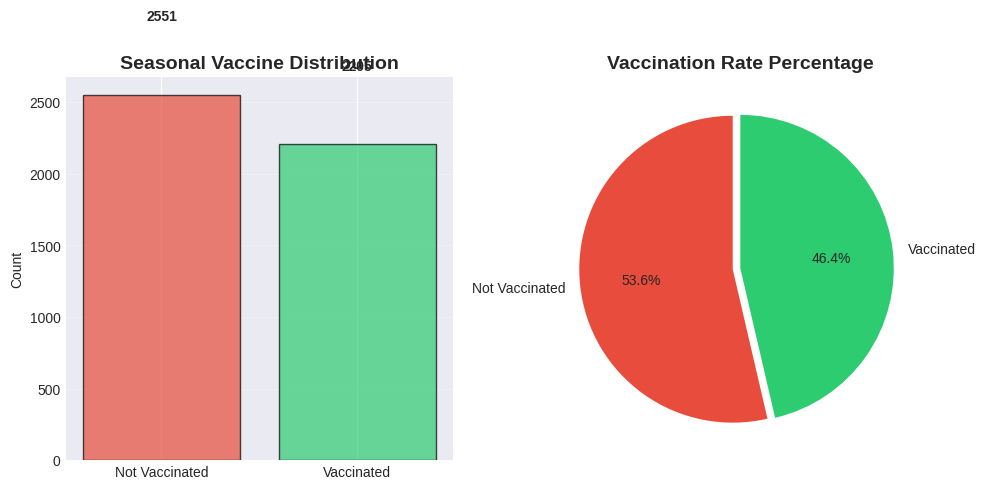


Target Variable Distribution:
  Not Vaccinated (0): 2,205 (46.4%)
  Vaccinated (1): 2,551 (53.6%)


In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
target_counts = train_df['seasonal_vaccine'].value_counts()
plt.bar(['Not Vaccinated', 'Vaccinated'], target_counts.values,
        color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
plt.title('Seasonal Vaccine Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

# Add count labels
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 500, str(v), ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(target_counts.values, labels=['Not Vaccinated', 'Vaccinated'],
        autopct='%1.1f%%', colors=['#e74c3c', '#2ecc71'], startangle=90,
        explode=(0.05, 0))
plt.title('Vaccination Rate Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTarget Variable Distribution:")
print(f"  Not Vaccinated (0): {target_counts[0]:,} ({target_counts[0]/len(train_df)*100:.1f}%)")
print(f"  Vaccinated (1): {target_counts[1]:,} ({target_counts[1]/len(train_df)*100:.1f}%)")


## Key Feature Distributions

### Numeric features

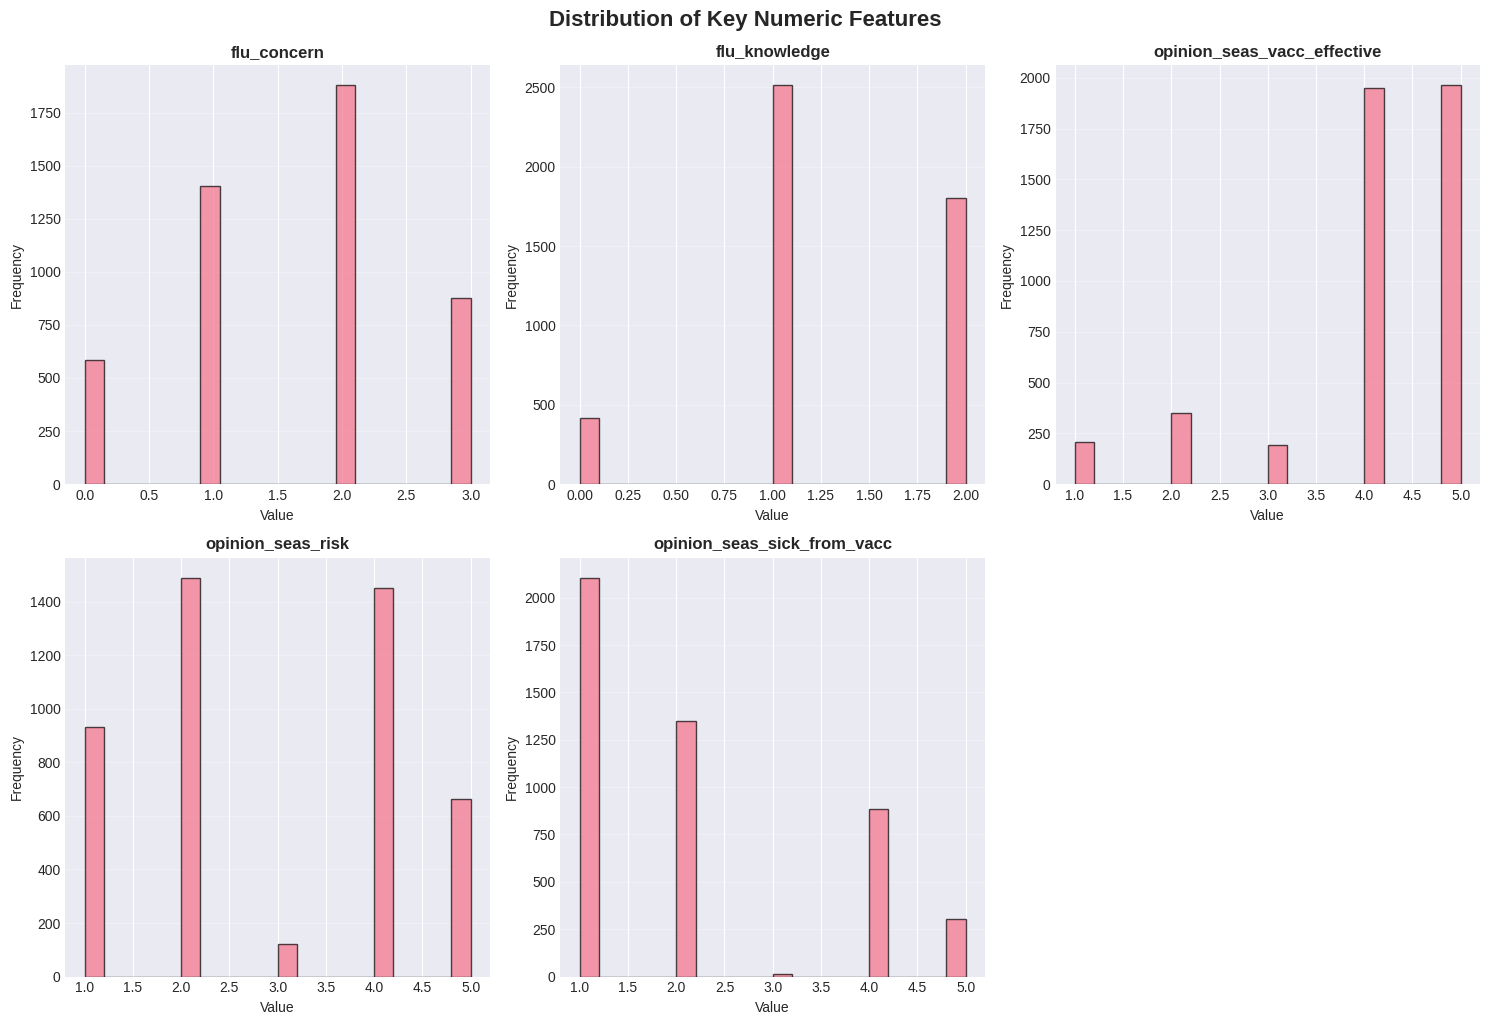

In [ ]:

numeric_features = ['flu_concern', 'flu_knowledge', 'opinion_seas_vacc_effective',
                   'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_features):
    if col in train_df.columns:
        train_df[col].hist(bins=20, ax=axes[idx], edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}', fontweight='bold')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(axis='y', alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.suptitle('Distribution of Key Numeric Features', y=1.02, fontsize=16, fontweight='bold')
plt.show()


### Categorical Feature Analysis

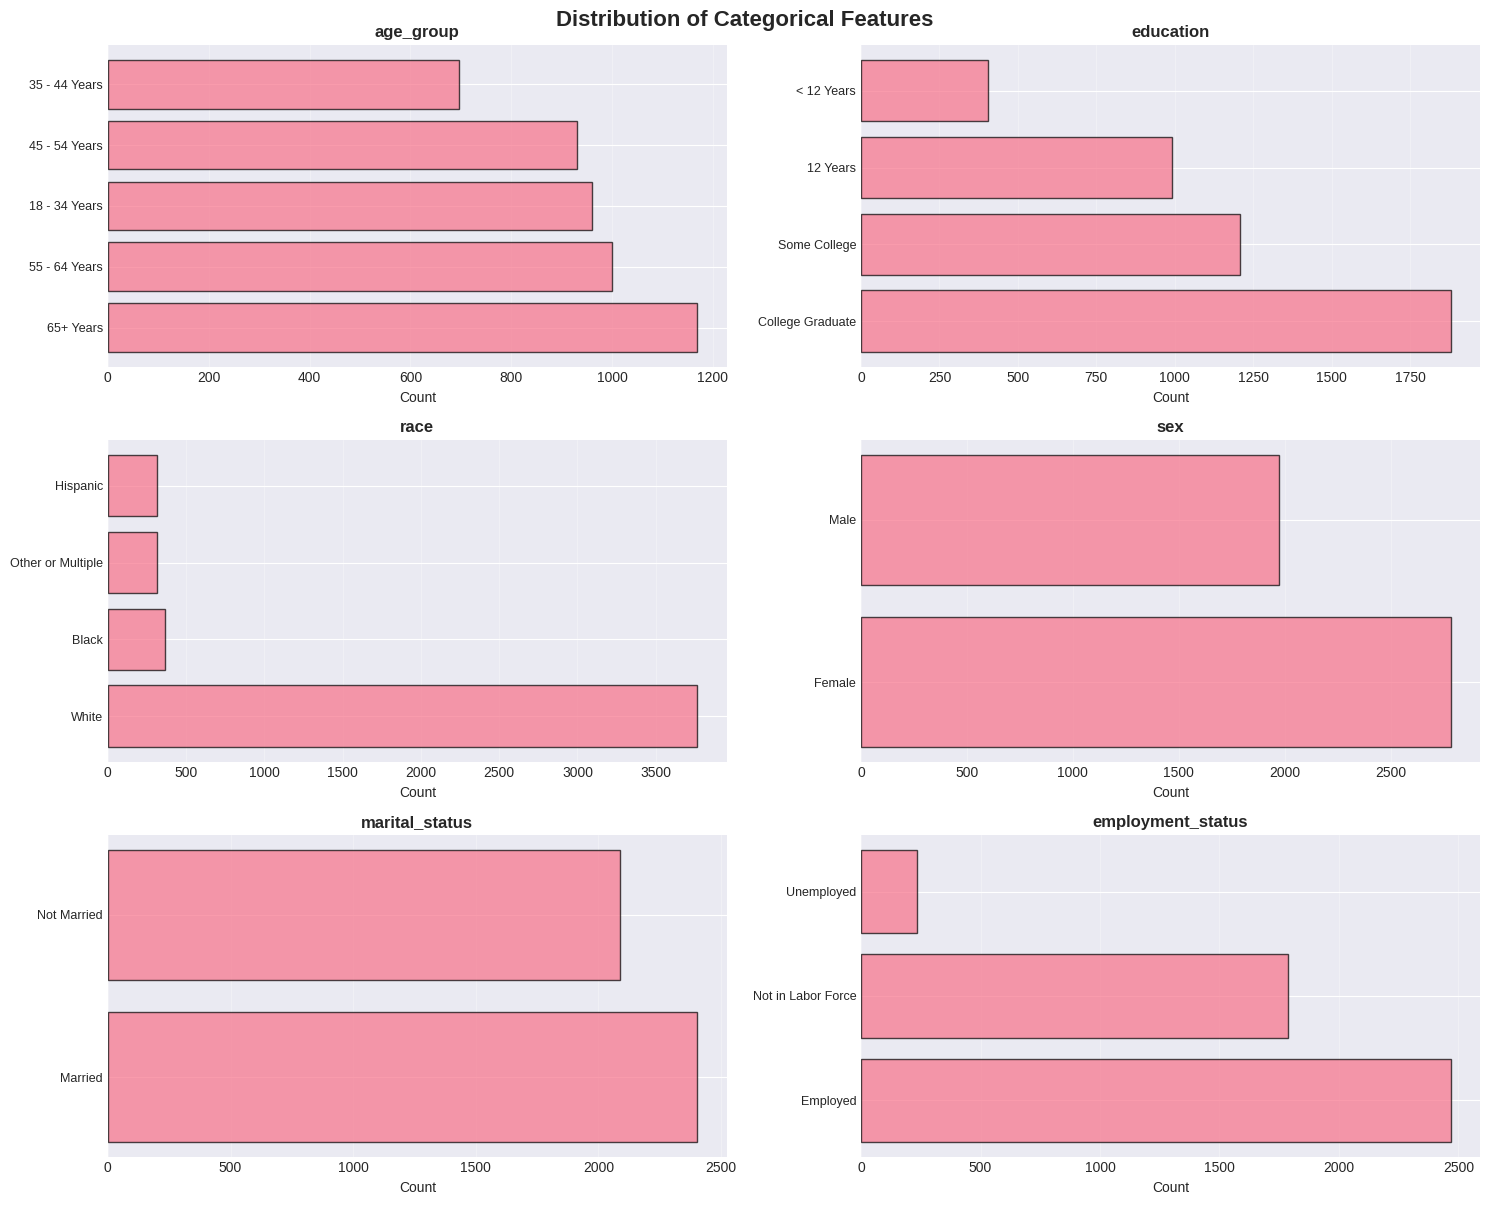

In [ ]:
categorical_features = ['age_group', 'education', 'race', 'sex', 'marital_status',
                       'employment_status']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(categorical_features):
    if col in train_df.columns:
        value_counts = train_df[col].value_counts().head(10)
        axes[idx].barh(range(len(value_counts)), value_counts.values, alpha=0.7, edgecolor='black')
        axes[idx].set_yticks(range(len(value_counts)))
        axes[idx].set_yticklabels(value_counts.index, fontsize=9)
        axes[idx].set_title(f'{col}', fontweight='bold')
        axes[idx].set_xlabel('Count')
        axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribution of Categorical Features', y=1.00, fontsize=16, fontweight='bold')
plt.show()

## Vaccination Rate by Key Demographics

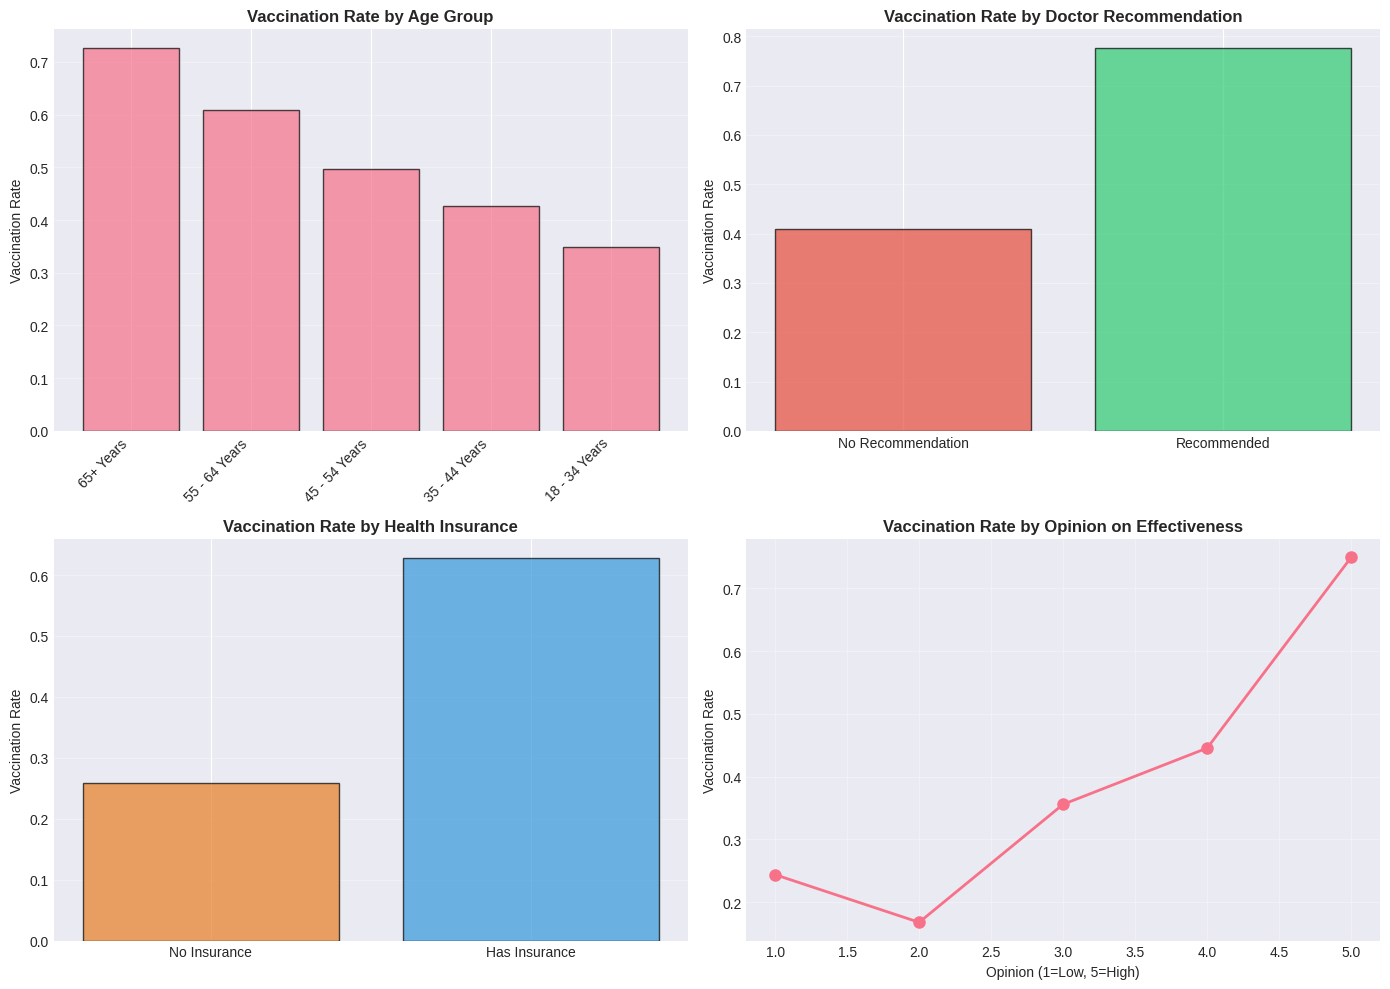

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age Group
age_vac = train_df.groupby('age_group')['seasonal_vaccine'].mean().sort_values(ascending=False)
axes[0, 0].bar(range(len(age_vac)), age_vac.values, alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(age_vac)))
axes[0, 0].set_xticklabels(age_vac.index, rotation=45, ha='right')
axes[0, 0].set_title('Vaccination Rate by Age Group', fontweight='bold')
axes[0, 0].set_ylabel('Vaccination Rate')
axes[0, 0].grid(axis='y', alpha=0.3)

# Doctor Recommendation
doc_rec = train_df.groupby('doctor_recc_seasonal')['seasonal_vaccine'].mean()
axes[0, 1].bar(['No Recommendation', 'Recommended'], doc_rec.values,
               color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Vaccination Rate by Doctor Recommendation', fontweight='bold')
axes[0, 1].set_ylabel('Vaccination Rate')
axes[0, 1].grid(axis='y', alpha=0.3)

# Health Insurance
if 'health_insurance' in train_df.columns:
    health_ins = train_df.groupby('health_insurance')['seasonal_vaccine'].mean()
    axes[1, 0].bar(['No Insurance', 'Has Insurance'], health_ins.values,
                   color=['#e67e22', '#3498db'], alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Vaccination Rate by Health Insurance', fontweight='bold')
    axes[1, 0].set_ylabel('Vaccination Rate')
    axes[1, 0].grid(axis='y', alpha=0.3)

# Opinion on Vaccine Effectiveness
opinion_vac = train_df.groupby('opinion_seas_vacc_effective')['seasonal_vaccine'].mean()
axes[1, 1].plot(opinion_vac.index, opinion_vac.values, marker='o', linewidth=2, markersize=8)
axes[1, 1].set_title('Vaccination Rate by Opinion on Effectiveness', fontweight='bold')
axes[1, 1].set_xlabel('Opinion (1=Low, 5=High)')
axes[1, 1].set_ylabel('Vaccination Rate')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Correlation Analysis (Numeric Features)

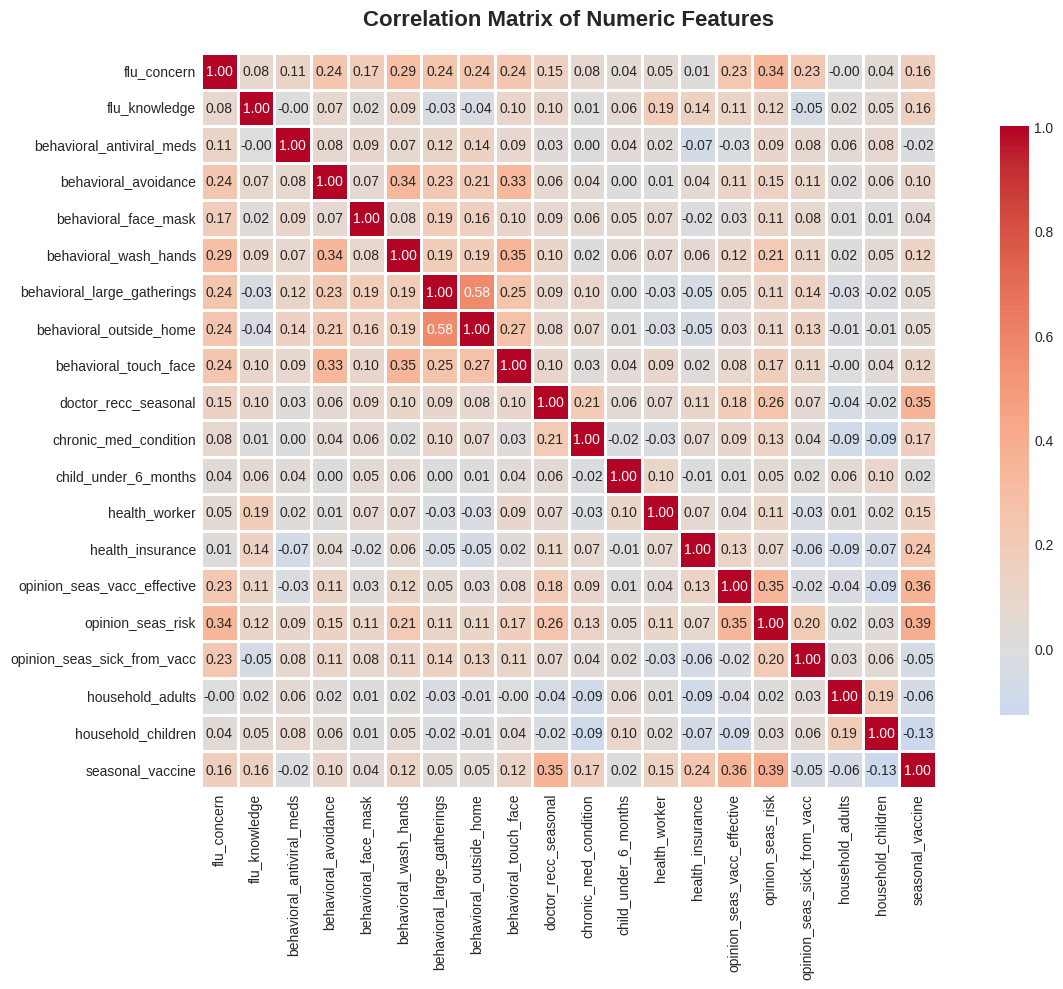

In [ ]:
# numeric columns to use for correlation
numeric_cols_for_corr = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'respondent_id' in numeric_cols_for_corr:
    numeric_cols_for_corr.remove('respondent_id')

plt.figure(figsize=(14, 10))
correlation_matrix = train_df[numeric_cols_for_corr].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



## Analysis of Target Variable Distribution and Feature Challenges

The dataset provides a robust foundation for binary classification, but presents notable challenges regarding missing data.

###  Target Variable Distribution

The target variable (vaccination status) shows a near-balanced split across the $4,756$ training samples:

| Status | Count | Percentage |
| :--- | :---: | :---: |
| **Vaccinated** | $2,551$ | $53.6\%$ |
| **Not Vaccinated** | $2,205$ | $46.4\%$ |

This balance minimizes class imbalance issues, although the slight skew toward vaccinated individuals might subtly bias model predictions in that direction.

###  Key Vaccination Trends (Feature Importance)

Demographic analysis aligns with public health expectations, showing significant vaccination trends linked to high-importance features:

| Feature | Importance Score | Trend |
| :--- | :---: | :--- |
| **doctor\_recc\_seasonal** | $0.5067$ | High uptake following a doctor’s recommendation. |
| **Age Group (65+ Years)** | $0.2649$ | Higher uptake in older age groups. |

###  Critical Data Challenges (Missingness)

The dataset's substantial missingness poses a critical challenge for reliable socioeconomic insights:

| Feature | Percentage Missing | Potential Impact |
| :--- | :---: | :--- |
| **employment\_sector** | $48.65\%$ | Gaps could distort employment-related vaccination patterns. |
| **health\_insurance** | $40.48\%$ | Substantial missingness could skew socioeconomic insights. |

If imputation methods fail to capture the underlying patterns within these gaps, the resulting features may be distorted.



# 3. DATA PREPROCESSING

In [ ]:
# Separate features and target
X = train_df.drop(['seasonal_vaccine', 'respondent_id'], axis=1)
y = train_df['seasonal_vaccine']

X_test = test_df.drop('respondent_id', axis=1)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Test feature matrix shape: {X_test.shape}")


Feature matrix shape: (4756, 29)
Target variable shape: (4756,)
Test feature matrix shape: (4749, 29)


## Identify Column Types

In [ ]:
# (0 or 1) binary features
binary_cols = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask',
               'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
               'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition',
               'child_under_6_months', 'health_worker', 'health_insurance']

# Ordinal features (ordered categories)
ordinal_cols = ['flu_concern', 'flu_knowledge', 'opinion_seas_vacc_effective',
                'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

# Numeric features
numeric_cols = ['household_adults', 'household_children']

# Categorical features (nominal)
categorical_cols = ['age_group', 'education', 'race', 'sex', 'income_poverty',
                   'marital_status', 'rent_or_own', 'employment_status',
                   'census_msa', 'employment_sector']

# Filter to only existing columns
binary_cols = [col for col in binary_cols if col in X.columns]
ordinal_cols = [col for col in ordinal_cols if col in X.columns]
numeric_cols = [col for col in numeric_cols if col in X.columns]
categorical_cols = [col for col in categorical_cols if col in X.columns]

print(f"\nColumn Type Classification:")
print(f"  Binary columns: {len(binary_cols)}")
print(f"  Ordinal columns: {len(ordinal_cols)}")
print(f"  Numeric columns: {len(numeric_cols)}")
print(f"  Categorical columns: {len(categorical_cols)}")


Column Type Classification:
  Binary columns: 12
  Ordinal columns: 5
  Numeric columns: 2
  Categorical columns: 10


## Create Preprocessing Pipeline

In [ ]:
# Binary feature pipeline
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# ordinal feature pipeline (with median, treated as numeric)
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Numeric feature pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical feature pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine all transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('bin', binary_transformer, binary_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

print("\n✓ Preprocessing pipeline created successfully!")
print("\nPipeline structure:")
print("  1. Binary features: Impute with mode")
print("  2. Ordinal features: Impute with median, scale")
print("  3. Numeric features: Impute with mean, scale")
print("  4. Categorical features: Impute with mode, one-hot encode")


✓ Preprocessing pipeline created successfully!

Pipeline structure:
  1. Binary features: Impute with mode
  2. Ordinal features: Impute with median, scale
  3. Numeric features: Impute with mean, scale
  4. Categorical features: Impute with mode, one-hot encode


## Split Training Data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\n✓ Data split completed:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Validation set: {X_val.shape[0]:,} samples")
print(f"  Test set: {X_test.shape[0]:,} samples")


✓ Data split completed:
  Training set: 3,804 samples
  Validation set: 952 samples
  Test set: 4,749 samples


## Feature Engineering and Preprocessing Pipeline

The preprocessing pipeline was designed to effectively categorize and process the diverse feature types in the dataset, enhancing robustness for the **4,756 samples** across **29 original features**.

### Feature Categorization and Imputation Strategy

The features were grouped, and tailored imputation strategies were applied to handle missing values:

| Feature Type | Count | Example | Imputation Strategy |
| :--- | :---: | :--- | :--- |
| **Binary** | 12 | *behavioral\_face\_mask* | Mode |
| **Ordinal** | 5 | *flu\_concern* | Median |
| **Numeric** | 2 | *household\_adults* | Mean |
| **Categorical** | 10 | *age\_group* | Mode |

### Scaling and Encoding

* **Scaling and Standardization** prepared the data for modeling, ensuring features contribute equally.
* **One-Hot Encoding** for categorical variables (like *age\_group* and *race*) expanded the feature space from 29 to potentially **over 50 dimensions**. This expansion was manageable given the sample size but risked overfitting without regularization.



# 4. MODEL BUILDING

In [ ]:
# dictionary to store results
model_results = {}


## Helper Function: Evaluate Model

In [ ]:
def evaluate_model(name, model, X_val, y_val):
    """
    Evaluate a trained model on validation data.
    Returns dictionary of performance metrics.
    """
    # Predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1-Score': f1_score(y_val, y_pred),
        'ROC-AUC': roc_auc_score(y_val, y_pred_proba)
    }

    # Print detailed results
    print(f"\n{'='*60}")
    print(f"{name.upper()}")
    print(f"{'='*60}")
    for metric, value in list(metrics.items())[1:]:
        print(f"{metric:.<30} {value:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=['Not Vaccinated', 'Vaccinated']))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Vaccinated', 'Vaccinated'],
                yticklabels=['Not Vaccinated', 'Vaccinated'])
    plt.title(f'Confusion Matrix - {name}', fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return metrics

## Model 2: Random Forest Classifier


 Training Model 2: Random Forest

RANDOM FOREST
Accuracy...................... 0.7742
Precision..................... 0.7891
Recall........................ 0.7906
F1-Score...................... 0.7898
ROC-AUC....................... 0.8359

Classification Report:
                precision    recall  f1-score   support

Not Vaccinated       0.76      0.76      0.76       441
    Vaccinated       0.79      0.79      0.79       511

      accuracy                           0.77       952
     macro avg       0.77      0.77      0.77       952
  weighted avg       0.77      0.77      0.77       952



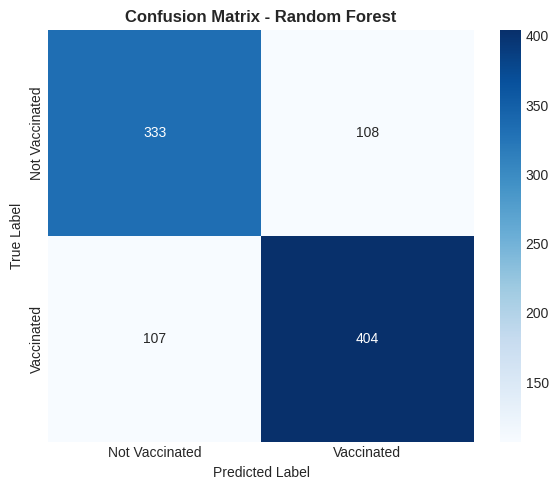

In [ ]:
print("\n Training Model 2: Random Forest")

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_metrics = evaluate_model('Random Forest', rf_pipeline, X_val, y_val)
model_results['Random Forest'] = rf_metrics